# WSQ Statistical Arbitrage Project - Impulse Candle Cross-Sectional Reversal Strategy

By William Keir

## Initial Idea

Impulse candles occur when price moves sharply in a one direction within a short time period. Qualitatively, they potentially indicate inefficient price movement as a result of aggressive buying or selling. Such movements could potentially be fuel for a price reversal. In this report, we explore a set of reversal strategies inspired by the qualitative characteristics of impulse candles.

In this project, we will defined an impulse candle as having:
- Returns from open to close greater than the rolling $x^{th}$ percentile of returns
- Volume greater than its fixed period moving average

Our strategy aims to identify impulse candles on the daily (1D) timeframe and trade a cross-sectional reversal on the hourly (1H) timeframe after the impulse candle occurs. Many variations of this strategy were tested, altering variables including:

- The return percentile threshold used to define impulse candles
- The volume moving average length and returns rolling percentile lookback period
- Lagging the percentile lookback period, altering the window of returns used to detect impulse candles
- Asset weighting methods, including equal weights and rank-based weights 
- Rank calculation methods, such as using the last 1 hour returns, or the full 1D returns
- The Lag between impulse detection, weight computation and trade execution (e.g., calculating weights based on the first hour after an impulse candle and entering at the start of the second hour)
- The number of assets held at any given time
- The definition of the 1D price window (i.e., shifting the window by 1hr increments)
- Scenarios where impulse candles are absent, excluded, or replaced with alternative conditions, for example:
    - High returns but low volume, and vice versa,
    - All 1D closes excluding those with impulse candles, 
    - All 1D closes regardless of candle type.
- Seasonality effects, including day of week and month of year patterns, though these yielded inconsistent results.

Through trialing and testing these variables, we identified a small collection of high-performing strategies. These were then combined into a portfolio to improve risk-adjusted performance and robustness. The resulting portfolio was tested using out-of-sample data to assess its robustness. A variety of performance metrics were measured, with additional analysis conducted to account for transaction costs. Regression analysis was also used to estimate factor exposures, including alpha and beta.

The strategy was implemented across a selected universe of 30 assets.

## Imports, Data Sourcing and Function Setup

All price-volume data was obtained using the Binance API. Custom functions used for data sourcing, backtesting and analysis are stored in the `functionsCode.py` file. Descriptions for each function can be found below.

### `get_data()` function

The `get_data()` function retrieves historical price data for a list of trading symbols from the Binance API, returning a multi-index DataFrame containing all requested information.

Inputs include:
- `univ` *(list[str])* –  List of asset tickers to source data for
- `freq` *(str)* – Frequency/interval of the data (e.g., '1h', '1d')
- `start_ts` *(str, 'YYYY-MM-DD')* –  Start timestamp; only data after this point will be included
- `end_ts` *(str, 'YYYY-MM-DD')* – End timestamp; only data before this point will be included
- `vars` *(list[str])* – Data variables to be sourced (e.g., `['close', 'volume']`)

### `impulse()` Function

To detect impulse candles, the `impulse()` function was created. This function takes several inputs that define the conditions for identifying an impulse candle,  and returns a pandas Series containing `1` for confirmed impulses and `np.nan` otherwise. 

Inputs include:

- `dfSlow` *(DataFrame)* – DataFrame containing price-volume data.
- `rollLen` *(int)* – Length of percentile rolling window.
- `volmaLen` *(int)* – Length of volume moving average.
- `percentile` *(int | float)* – Percentile threshold for signal generation.
- `pctShift` *(int)* – Number of periods to shift the percentile window.
- `alt` *(bool)* – If `True`, the strategy selects candles that *do not* meet the selected impulse candle criteria
- `type` *(int)* – Logic selector for signal generation. Values from 1 to 6 define different conditions used to identify impulse candles.

### `backtest()` Function

To backtest strategies, a custom `backtest()` function was created. This function takes several inputs that vary signal parameters, portfolio construction and execution assumptions, producing a pandas Series of hourly strategy returns.

Inputs include:

- `dfSlow` *(DataFrame)* – DataFrames containing price-volume data used to detect impulse candles.
- `dfFast` *(DataFrame)* – DataFrames containing price-volume data used to calculate strategy returns.
- `rollLen` *(int)* – Length of percentile rolling window.
- `volmaLen` *(int)* – Length of volume moving average.
- `percentile` *(int | float)* – Percentile threshold for signal generation.
- `pctShift` *(int)* – Number of periods to shift the percentile window.
- `alt` *(bool)* – If `True`, the strategy selects candles that *do not* meet the selected impulse candle criteria
- `lags` *(list[int])* – List of execution lags. Negative values represent buying underperformers and selling outperformers, positive values represent the opposite. The magnitude indicates how many 1-hour windows the position is held. For example, [-1, -2, -3] trades the reversal, holding positions for the first 3 hours after the signal is generated.
- `split` *(int)* – Number of assets held in each direction.
- `type` *(int)* – Logic selector for signal generation. Values from 1 to 6 define different conditions used to identify impulse candles.
- `sigLag`*(int)* – Lag between impulse detection and weight calculation. Rather than lagging the trade signal, this lags the window used to compute asset weights. For example, `sigLag = 1` will compute weights based on the first hour returns after an impulse candle is detected, then enter the trade at the start of the second hour.
- `tcosts` *(bool)* – If `True`, applies transaction cost penalties and accounts for relative weight changes due to lack of rebalancing.

### `basic_XC()` Function

The `basic_XC()` function implements a simple cross-sectional (XS) reversal strategy. Using a dataframe of hourly returns, it ranks assets by returns, taking long positions in the 15 underperforming assets and short positions in the 15 outperforming assets. Equal weights are applied to each asset. Positions are held for 1 hour before the strategy is rebalanced. This strategy will be used as a benchmark for regression analysis.

### `performance_metrics()` Function

The `performance_metrics()` function computes and returns a variety of performance metrics for a given strategy's return series. These metrics include: 

- Annualised Sharpe Ratio
- Maximum Drawdown (%)
- Win Rate (%)
- Annualised Returns (%)
- Average Returns per Trade (%)
- Average Winning Trade (%)
- Average Losing Trade (%) 
- Largest Winning Trade (%)
- Largest Losing Trade (%)

The function returns these metrics as a pandas DataFrame.


In [8]:
# Imports
import functionsCode as fn

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

In [9]:
# Information for sourcing data
# Data start and end date
start_ts = '2017-12-31'
end_ts = '2026-01-01'

# Assets
univ = [
    'BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'XRPUSDT', 'LTCUSDT', 
    'BNBUSDT', 'ADAUSDT', 'DOTUSDT', 'LINKUSDT', 'UNIUSDT', 
    'TRXUSDT', 'XLMUSDT', 'ETCUSDT', 'BCHUSDT', 'VETUSDT', 
    'NEOUSDT', 'ZECUSDT', 'DASHUSDT', 'IOTAUSDT', 'ATOMUSDT', 
    'MKRUSDT', 'COMPUSDT', 'DOGEUSDT', 'CRVUSDT', 'ONTUSDT',
    'ALGOUSDT', 'ICPUSDT', 'SUSHIUSDT', 'TRBUSDT', 'SHIBUSDT'
]

In [12]:
# Download Data
# Slow data: used to detect impulse candles
dfSlow = fn.get_data(univ, '1d', start_ts, end_ts, ['close', 'volume'])

# Fast Data: used for trading after a signal is received
dfFast = fn.get_data(univ, '1h', start_ts, end_ts, ['close'])

In [13]:
# Split data into in-sample and out-of-sample components
# Copy data

# In Sample Data
dfSlowIS = dfSlow[(dfSlow.index < pd.to_datetime('2024-01-01'))]
dfFastIS = dfFast[(dfFast.index < pd.to_datetime('2024-01-01'))]

retsFastIS = dfFastIS.xs('close', axis=1, level=1).pct_change()[1:]

# Out of Sample Data
dfSlowOOS = dfSlow[dfSlow.index >= pd.to_datetime('2024-01-01')]
dfFastOOS = dfFast[dfFast.index >= pd.to_datetime('2024-01-01')]

retsFastOOS = dfFastOOS.xs('close', axis=1, level=1).pct_change()[1:]

## In-Sample Testing

In this section, we describe each strategy, producing backtested results on in-sample data.

### Strategy 1 


At the close of every 1D candle, wait one hour, then based on the returns in the last hour, long the 8 lowest performing assets and short the 8 highest performing assets, all with equal weight. Hold this position for 8 hours then close all positions. 

Sharpe Ratio Before Fees: 3.814


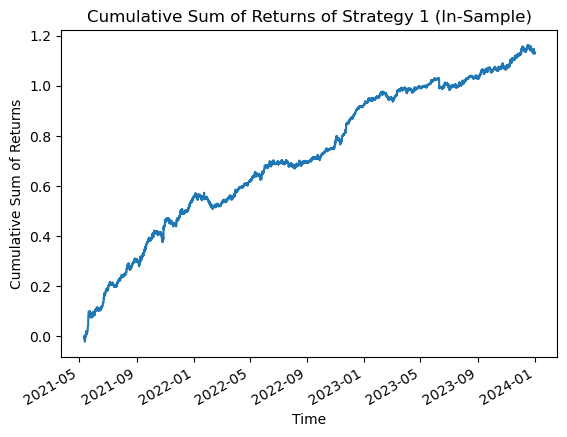

In [17]:
# Strategy 1
rets1IS = fn.backtest(dfSlowIS, dfFastIS, 
               lags=[-1, -2, -3, -4, -5, -6, -7, -8], 
               split=8,
               type=6,
               sigLag=1
)

sharpe1IS = rets1IS.mean() / rets1IS.std() * np.sqrt(365*24)
print("Sharpe Ratio Before Fees: " + str(round(sharpe1IS, 3)))

ax = rets1IS.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of Strategy 1 (In-Sample)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.show()

In [18]:
# Performance Metrics
print("Strategy 1 - In-Sample Performance")
fn.performance_metrics(rets1IS)

Strategy 1 - In-Sample Performance


,Metric,Value
0,Sharpe Ratio,3.814
1,Max Drawdown (%),6.269
2,Win Rate (%),59.544
3,Annualised Returns (%),52.359
4,Average Returns per Trade (%),0.197
5,Average Winning Trade (%),0.457
6,Average Losing Trade (%),-0.383
7,Largest Winning Trade (%),4.472
8,Largest Losing Trade (%),-2.790


### Strategy 2

At the close of every 1D candle, determine if the returns were larger than the median of the last 14 candles (excluding the last candle). If so, wait one hour, then based on the returns in the last hour, long the 8 lowest performing assets and short the 8 highest performing assets, all with equal weight. Hold this position for 3 hours then close all positions. 

Sharpe Ratio Before Fees: 3.327


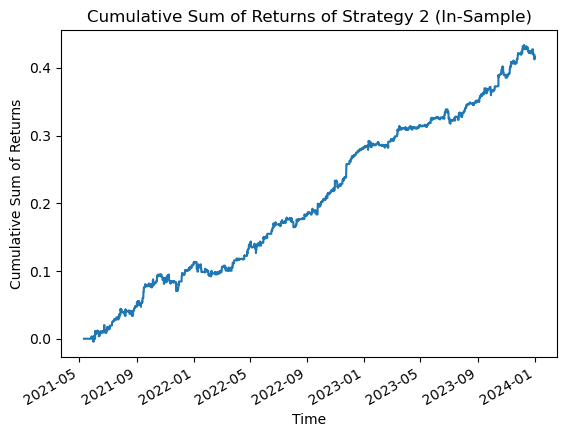

In [22]:
# Strategy 2
rets2IS = fn.backtest(dfSlowIS, dfFastIS, 
               percentile=50,
               pctShift=1,
               lags=[-1, -2, -3], 
               split=8,
               type=5,
               sigLag=1
)

sharpe2IS = rets2IS.mean() / rets2IS.std() * np.sqrt(365*24)
print("Sharpe Ratio Before Fees: " + str(round(sharpe2IS, 3)))

ax = rets2IS.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of Strategy 2 (In-Sample)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.show()

In [23]:
# Performance Metrics
print("Strategy 2 - In-Sample Performance")
fn.performance_metrics(rets2IS)

Strategy 2 - In-Sample Performance


,Metric,Value
0,Sharpe Ratio,3.327
1,Max Drawdown (%),2.448
2,Win Rate (%),61.783
3,Annualised Returns (%),16.915
4,Average Returns per Trade (%),0.143
5,Average Winning Trade (%),0.284
6,Average Losing Trade (%),-0.229
7,Largest Winning Trade (%),1.775
8,Largest Losing Trade (%),-1.312


### Strategy 3

At the close of every 1D candle, wait one hour, then based on the returns in the last hour, long the 10 lowest performing assets and short the 10 highest performing assets. Hold this position for 3 hours then close all positions. 

Sharpe Ratio Before Fees: 3.903


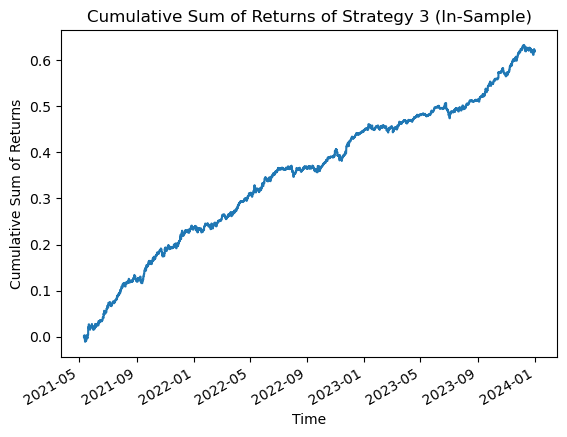

In [25]:
# Strategy 3
rets3IS = fn.backtest(dfSlowIS, dfFastIS,
               lags=[-1, -2, -3],
               split=10,
               type=6,
               sigLag=1
)

sharpe3IS = rets3IS.mean() / rets3IS.std() * np.sqrt(365*24)
print("Sharpe Ratio Before Fees: " + str(round(sharpe3IS, 3)))

ax = rets3IS.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of Strategy 3 (In-Sample)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.show()

In [26]:
# Performance Metrics
print("Strategy 3 - In-Sample Performance")
fn.performance_metrics(rets3IS)

Strategy 3 - In-Sample Performance


,Metric,Value
0,Sharpe Ratio,3.903
1,Max Drawdown (%),3.259
2,Win Rate (%),59.855
3,Annualised Returns (%),26.246
4,Average Returns per Trade (%),0.108
5,Average Winning Trade (%),0.251
6,Average Losing Trade (%),-0.214
7,Largest Winning Trade (%),1.646
8,Largest Losing Trade (%),-1.193


### Portfolio of Strategies

The 3 strategies above were combined into a portfolio with equal weight allocation to each. This allocation was chosen as it produced the most consistant results, and doesn't rely heavily on any particular strategy.

Portfolio of Strategies - In-Sample Performance
Sharpe Ratio Before Fees: 4.419


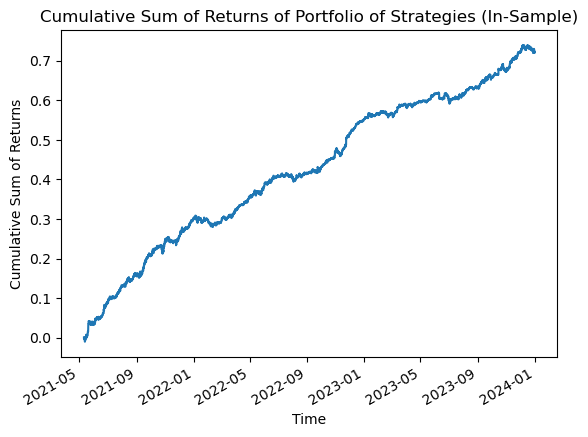

In [28]:
# Portfolio of Strategies
portIS = (rets1IS + rets2IS + rets3IS)/3
sharpePortIS = portIS.mean() / portIS.std() * np.sqrt(365*24)

print("Portfolio of Strategies - In-Sample Performance")
print("Sharpe Ratio Before Fees: " + str(round(sharpePortIS, 3)))

ax = portIS.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of Portfolio of Strategies (In-Sample)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.show()

In [29]:
# Performance Metrics
print("Portfolio of Strategies - In-Sample Performance")
fn.performance_metrics(portIS)

Portfolio of Strategies - In-Sample Performance


,Metric,Value
0,Sharpe Ratio,4.419
1,Max Drawdown (%),2.825
2,Win Rate (%),61.411
3,Annualised Returns (%),31.166
4,Average Returns per Trade (%),0.122
5,Average Winning Trade (%),0.254
6,Average Losing Trade (%),-0.210
7,Largest Winning Trade (%),2.028
8,Largest Losing Trade (%),-1.065


From in-sample testing, Strategy 3 achieved the highest Sharpe ratio of 3.90. Strategy 2 recoreded the lowest maximum drawdown at 2.45% and the highest win rate of 61.78%. Strategy 2 is more selective with trades, only entering positions when the 1-day returns are greater than the median, whereas the others enter after every 1-day close. This selectivity likely leads to higher quality trades, providing a possible explanation for its lower max drawdown and higher win rate. However, due to it holding cash positions for longer periods than the other strategies, the Sharpe ratio of Strategy 2 is reduced. As such, the Sharpe ratio may be a misleading measurement of risk-adjsted performance for this strategy.

The portfolio of strategies yields a Sharpe ratio of 4.42, with a maximum drawdown of 2.83% and a win rate of 61.41%. The portfolio benefits from the strong risk-adjusted returns of Strategies 1 and 3, while also incorporating the higher win rate and reduced drawdown characteristics of Strategy 2, resulting in an overall improvement in performance compared to each strategy on their own.

## Out of Sample Testing

In this section, we evaluate the performance of each strategy on out-of-sample data to assess robustness. 

### Strategy 1

Strategy 1 - Out-of-Sample
Sharpe Ratio Before Fees: 3.431


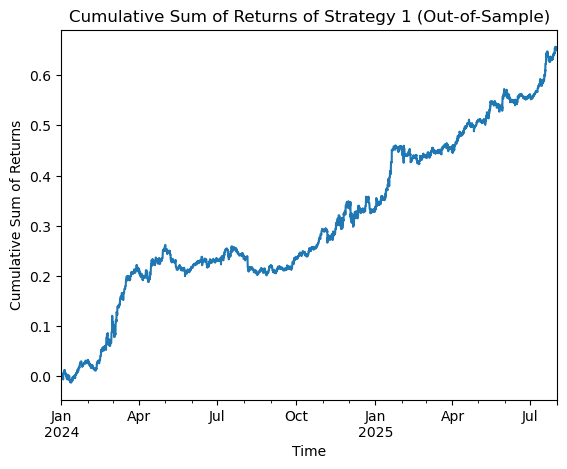

In [31]:
rets1OOS = fn.backtest(dfSlowOOS, dfFastOOS, 
               lags=[-1, -2, -3, -4, -5, -6, -7, -8], 
               split=8, 
               type=6,
               sigLag=1
)

sharpe1OOS = rets1OOS.mean() / rets1OOS.std() * np.sqrt(365*24)

print("Strategy 1 - Out-of-Sample")
print("Sharpe Ratio Before Fees: " + str(round(sharpe1OOS, 3)))

ax = rets1OOS.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of Strategy 1 (Out-of-Sample)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.show()

In [32]:
print("Strategy 1 - Out-of-Sample Performance")
fn.performance_metrics(rets1OOS)

Strategy 1 - Out-of-Sample Performance


,Metric,Value
0,Sharpe Ratio,3.431
1,Max Drawdown (%),6.065
2,Win Rate (%),57.439
3,Annualised Returns (%),50.019
4,Average Returns per Trade (%),0.197
5,Average Winning Trade (%),0.493
6,Average Losing Trade (%),-0.400
7,Largest Winning Trade (%),2.684
8,Largest Losing Trade (%),-2.703


### Strategy 2

Strategy 2 - Out-of-Sample
Sharpe Ratio Before Fees: 2.062


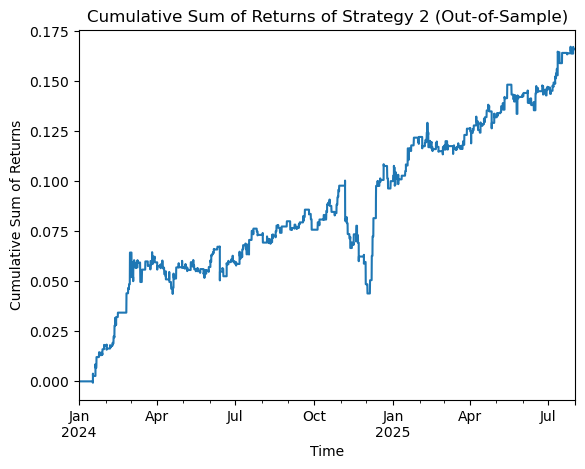

In [34]:
rets2OOS = fn.backtest(dfSlowOOS, dfFastOOS, 
               percentile=50,
               pctShift=1,
               lags=[-1, -2, -3], 
               split=8, 
               type=5,
               sigLag=1
)

sharpe2OOS = rets2OOS.mean() / rets2OOS.std() * np.sqrt(365*24)

print("Strategy 2 - Out-of-Sample")
print("Sharpe Ratio Before Fees: " + str(round(sharpe2OOS, 3)))

ax = rets2OOS.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of Strategy 2 (Out-of-Sample)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.show()

In [35]:
# Performance Metrics
print("Strategy 2 - Out-of-Sample Performance")
fn.performance_metrics(rets2OOS)

Strategy 2 - Out-of-Sample Performance


,Metric,Value
0,Sharpe Ratio,2.062
1,Max Drawdown (%),5.509
2,Win Rate (%),57.895
3,Annualised Returns (%),10.884
4,Average Returns per Trade (%),0.108
5,Average Winning Trade (%),0.301
6,Average Losing Trade (%),-0.265
7,Largest Winning Trade (%),1.619
8,Largest Losing Trade (%),-1.745


### Strategy 3

Strategy 3 - Out-of-Sample
Sharpe Ratio Before Fees: 2.555


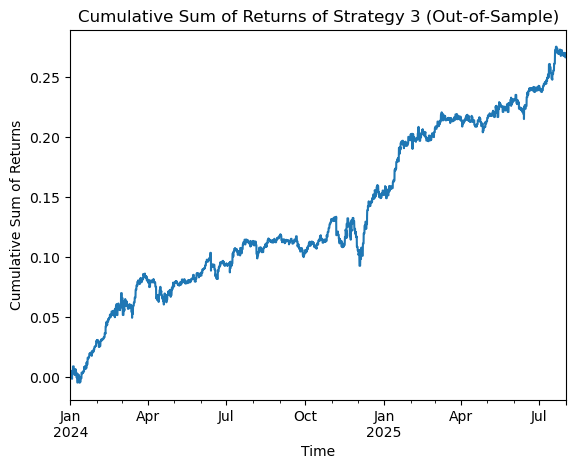

In [37]:
rets3OOS = fn.backtest(dfSlowOOS, dfFastOOS, 
               lags=[-1, -2, -3],
               split=10, 
               type=6,
               sigLag=1
)

sharpe3OOS = rets3OOS.mean() / rets3OOS.std() * np.sqrt(365*24)

print("Strategy 3 - Out-of-Sample")
print("Sharpe Ratio Before Fees: " + str(round(sharpe3OOS, 3)))

ax = rets3OOS.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of Strategy 3 (Out-of-Sample)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.show()

In [38]:
# Performance Metrics
print("Strategy 3 - Out-of-Sample Performance")
fn.performance_metrics(rets3OOS)

Strategy 3 - Out-of-Sample Performance


,Metric,Value
0,Sharpe Ratio,2.555
1,Max Drawdown (%),4.067
2,Win Rate (%),56.574
3,Annualised Returns (%),18.245
4,Average Returns per Trade (%),0.082
5,Average Winning Trade (%),0.254
6,Average Losing Trade (%),-0.224
7,Largest Winning Trade (%),1.175
8,Largest Losing Trade (%),-1.398


### Portfolio of Strategies

Portfolio of Strategies - Out-of-Sample Performance
Sharpe Ratio Before Fees: 3.4


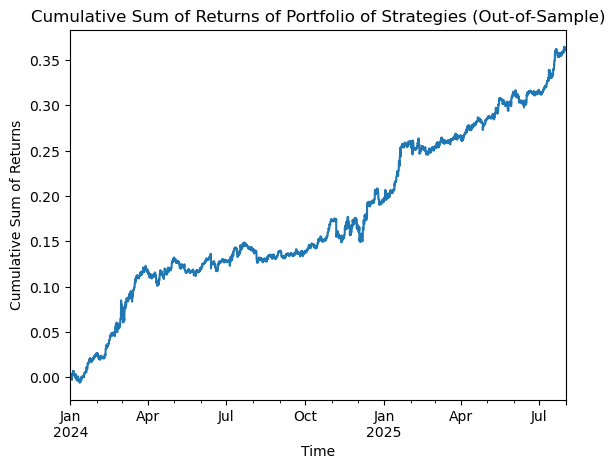

In [40]:
# Portfolio of Strategies
portOOS = (rets1OOS + rets2OOS + rets3OOS)/3
sharpePortOOS = portOOS.mean() / portOOS.std() * np.sqrt(365*24)

print("Portfolio of Strategies - Out-of-Sample Performance")
print("Sharpe Ratio Before Fees: " + str(round(sharpePortOOS, 3)))

ax = portOOS.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of Portfolio of Strategies (Out-of-Sample)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.show()

In [41]:
print("Portfolio of Strategies - Out-of-Sample Performance")
fn.performance_metrics(portOOS)

Portfolio of Strategies - Out-of-Sample Performance


,Metric,Value
0,Sharpe Ratio,3.400
1,Max Drawdown (%),2.728
2,Win Rate (%),58.824
3,Annualised Returns (%),25.458
4,Average Returns per Trade (%),0.107
5,Average Winning Trade (%),0.264
6,Average Losing Trade (%),-0.225
7,Largest Winning Trade (%),1.579
8,Largest Losing Trade (%),-1.690


The out-of-sample results show that Strategy 1 maintained strong performance, with its Sharpe ratio falling slightly from 3.81 to 3.43. Strategies 2 and 3 both saw larger reductions to their Sharpe ratio's, with Strategy 2 dropping from 3.33 to 2.06, and Strategy 3 from 3.90 to 2.56. Notably, Strategy 2 also saw an increase in maximum drawdown, rising from 2.45% to 5.51%. The portfolio of strategies also saw a reduction in its Sharpe ratio, falling to from 4.42 to 3.40. Despite these reductions in risk-adjusted performance, the strategies remain sufficiently robust.

Next, we evaluate the impact of transaction costs on strategy performance, under specified assumptions.

## Accounting for Transaction Costs

Transaction costs must be accounted for to assess the viability of these strategies in live trading. These costs include slippage and exchange fees. For strategies of this nature, it is better to automate trade execution, as the strategies require weight calculation based of many criteria, and trade duration is relatively short. This will allow easy implementation of limit orders for executing trades. Limit orders incur lower fees paid to the exchange, and experience no slippage, minimising the impact of fees on performance. However, they come with the added risk of partial or unfilled positions, which will affect performance.

To reduce transaction costs, it is better to buy and hold positions without rebalancing mid-trade. The original strategies assume equal weight across assets throughout each trade, however, due to differences in relative performance between assets, buying and holding will result in percentage allocation to each asset changing over the duration of the trade. This deviation will impact the overall performance of the strategy, and must be accounted for when assessing each strategy's viability in live trading. Avoiding rebalancing mid-trade reduces how often we are entering and exiting positions, minimising transaction costs and improving after-fee performance. 

For this analysis, we will assume 7 basis points for transaction costs, incurring 3.5 basis points on entry and 3.5 on exit. We will start by assessing the in-sample performance after accounting for transaction costs.

Strategy 1 - In-Sample, After Fees
Sharpe Ratio After Fees: 1.528


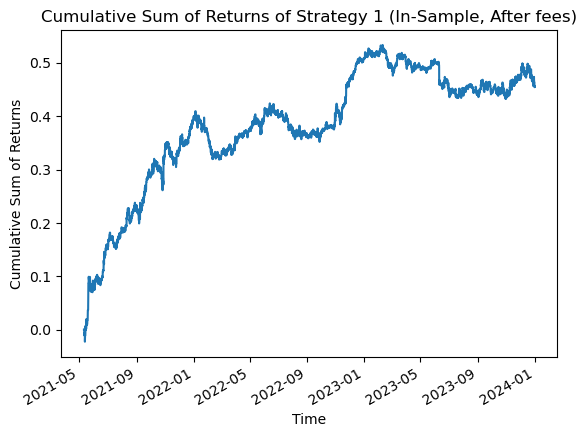

In [43]:
# Strategy 1
rets1ISFees = fn.backtest(dfSlowIS, dfFastIS, 
               lags=[-1, -2, -3, -4, -5, -6, -7, -8], 
               split=8,
               type=6,
               sigLag=1,
               tcosts=True
)

sharpe1ISFees = rets1ISFees.mean() / rets1ISFees.std() * np.sqrt(365*24)

print("Strategy 1 - In-Sample, After Fees")
print("Sharpe Ratio After Fees: " + str(round(sharpe1ISFees, 3)))

ax = rets1ISFees.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of Strategy 1 (In-Sample, After fees)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.show()

In [44]:
print("Strategy 1 - In-Sample Performance, After Transaction Costs")
fn.performance_metrics(rets1ISFees)

Strategy 1 - In-Sample Performance, After Transaction Costs


,Metric,Value
0,Sharpe Ratio,1.528
1,Max Drawdown (%),9.887
2,Win Rate (%),53.942
3,Annualised Returns (%),18.057
4,Average Returns per Trade (%),0.088
5,Average Winning Trade (%),0.432
6,Average Losing Trade (%),-0.403
7,Largest Winning Trade (%),5.079
8,Largest Losing Trade (%),-2.846


Strategy 2 - In-Sample, After Fees
Sharpe Ratio After Fees: 0.698


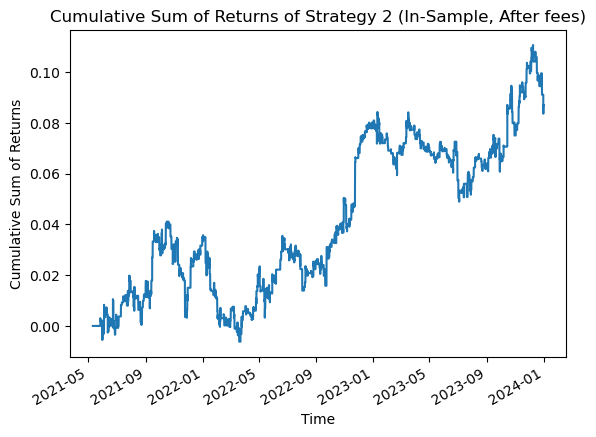

In [45]:
# Strategy 2
rets2ISFees = fn.backtest(dfSlowIS, dfFastIS, 
               percentile=50,
               pctShift=1,
               lags=[-1, -2, -3],
               split=8,
               type=5,
               sigLag=1,
               tcosts=True,
)

sharpe2ISFees = rets2ISFees.mean() / rets2ISFees.std() * np.sqrt(365*24)

print("Strategy 2 - In-Sample, After Fees")
print("Sharpe Ratio After Fees: " + str(round(sharpe2ISFees, 3)))

ax = rets2ISFees.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of Strategy 2 (In-Sample, After fees)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.show()

In [46]:
print("Strategy 2 - In-Sample Performance, After Transaction Costs")
fn.performance_metrics(rets2ISFees)

Strategy 2 - In-Sample Performance, After Transaction Costs


,Metric,Value
0,Sharpe Ratio,0.698
1,Max Drawdown (%),4.673
2,Win Rate (%),52.017
3,Annualised Returns (%),3.234
4,Average Returns per Trade (%),0.036
5,Average Winning Trade (%),0.262
6,Average Losing Trade (%),-0.246
7,Largest Winning Trade (%),1.757
8,Largest Losing Trade (%),-1.441


Strategy 3 - In-Sample, After Fees
Sharpe Ratio After Fees: -0.328


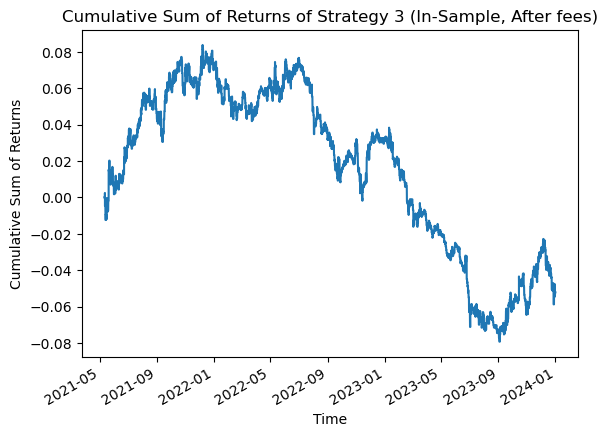

In [47]:
# Strategy 3
rets3ISFees = fn.backtest(dfSlowIS, dfFastIS,
               lags=[-1, -2, -3],
               split=10,
               type=6,
               sigLag=1,
               tcosts=True
)

sharpe3ISFees = rets3ISFees.mean() / rets3ISFees.std() * np.sqrt(365*24)

print("Strategy 3 - In-Sample, After Fees")
print("Sharpe Ratio After Fees: " + str(round(sharpe3ISFees, 3)))

ax = rets3ISFees.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of Strategy 3 (In-Sample, After fees)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.show()

In [48]:
print("Strategy 3 - In-Sample Performance, After Transaction Costs")
fn.performance_metrics(rets3ISFees)

Strategy 3 - In-Sample Performance, After Transaction Costs


,Metric,Value
0,Sharpe Ratio,-0.328
1,Max Drawdown (%),15.272
2,Win Rate (%),48.237
3,Annualised Returns (%),-2.131
4,Average Returns per Trade (%),-0.011
5,Average Winning Trade (%),0.233
6,Average Losing Trade (%),-0.228
7,Largest Winning Trade (%),1.630
8,Largest Losing Trade (%),-1.286


Portfolio of Strategies - In Sample, After Fees
Sharpe Ratio After Fees: 1.0


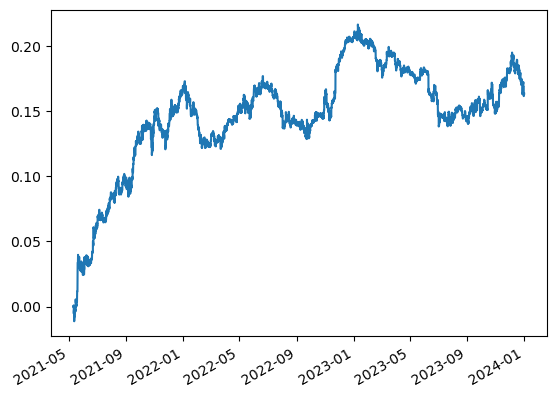

In [49]:
portISFees = (rets1ISFees + rets2ISFees + rets3ISFees)/3
sharpePortISFees = portISFees.mean() / portISFees.std() * np.sqrt(365*24)

print("Portfolio of Strategies - In Sample, After Fees")
print("Sharpe Ratio After Fees: " + str(round(sharpePortISFees, 3)))

portISFees.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of Portfolio of Strategies (In-Sample, After fees)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.show()

In [50]:
print("Portfolio of Strategies - In-Sample Performance, After Transaction Costs")
fn.performance_metrics(portISFees)

Portfolio of Strategies - In-Sample Performance, After Transaction Costs


,Metric,Value
0,Sharpe Ratio,1.000
1,Max Drawdown (%),7.584
2,Win Rate (%),50.830
3,Annualised Returns (%),6.178
4,Average Returns per Trade (%),0.033
5,Average Winning Trade (%),0.243
6,Average Losing Trade (%),-0.217
7,Largest Winning Trade (%),2.220
8,Largest Losing Trade (%),-1.159


After accounting for fees, all strategies saw a significant reduction in performance. The Sharpe ratio of Strategy 1 reduced from 3.81 to 1.53; Strategy 2 fell from 3.33 to 0.70; and Strategy 3 fell from 3.90 to -0.33. The portfolio of strategies also saw its Sharpe ratio fall, from 4.42 to 1.00. Clearly, some adjustments will need to be made to mitigate the effect of transaction costs if we wish to trade these strategies live.

One way we can lower the impact of transaction costs is to reduce the number of assets hed at any given time. This increases the returns of the overall strategy, since more capital is concentrated in the more volatile assets. This comes at a cost of before-fee risk adjusted performance, as the volatility of returns increases by a larger factor. The increase in strategy returns reduces the relative effect of transaction costs, resulting in an overall improvement to after-fee risk-adjusted performance. Strategy 3 involves holding the 10 highest and lowest performers at any given time (20 assets in total), more than either of the other strategies. As a result, we saw a significant impact to the after-fee performance of this strategy, to the point where it generating negative average returns.

Another method of reducing the impact of transaction costs includes holding the positions for longer periods of time. Longer hold periods extends the exposure of each strategy to the market, allowing for potentially higher returns at the cost of risk-adjusted performance. As a result, this increase in hold time reduces the relative effect of transaction costs, improving after-fee risk-adjusted performance. Of the 3 strategies, Strategies 2 and 3 held its trades for the shortest duration (3 hours compared to 8 hours for Strategy 1). Due to this, it saw a significant impact to its after-fee risk-adjusted performance, with the Sharpe ratio of Strategy 2 falling below 1.

Below, different variations of the same strategies were tested, changing the number of assets held and the hold duration. These changes have improved overall risk-adjusted performance of each strategy and the portfolio of strategies, after accounting for transaction costs.

### Altering Strategies to Optimise for After-Fee Performance

#### New Strategy 1

- Changed split from 8 to 2 (now long the underperforming 2 assets and short the outperforming 2)

New Strategy 1 - In-Sample, After Fees
Sharpe Ratio After Fees: 1.79


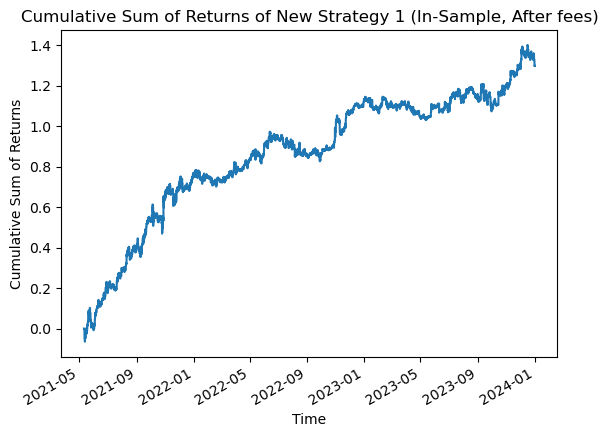

In [52]:
# Strategy 1
rets1v2ISFees = fn.backtest(dfSlowIS, dfFastIS, 
               lags=[-1, -2, -3, -4, -5, -6, -7, -8], 
               split=2, # changed from 8
               type=6,
               sigLag=1,
               tcosts=True
)

sharpe1v2ISFees = rets1v2ISFees.mean() / rets1v2ISFees.std() * np.sqrt(365*24)

print("New Strategy 1 - In-Sample, After Fees")
print("Sharpe Ratio After Fees: " + str(round(sharpe1v2ISFees, 3)))

ax = rets1v2ISFees.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of New Strategy 1 (In-Sample, After fees)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.show()

In [53]:
print("Strategy 1 - In-Sample Performance, Adjusted for Transaction Costs")
fn.performance_metrics(rets1v2ISFees)

Strategy 1 - In-Sample Performance, Adjusted for Transaction Costs


,Metric,Value
0,Sharpe Ratio,1.790
1,Max Drawdown (%),14.403
2,Win Rate (%),55.602
3,Annualised Returns (%),57.351
4,Average Returns per Trade (%),0.240
5,Average Winning Trade (%),0.984
6,Average Losing Trade (%),-0.932
7,Largest Winning Trade (%),7.662
8,Largest Losing Trade (%),-6.872


#### New Strategy 2

- Changed split from 8 to 2

New Strategy 2 - In-Sample, After Fees
Sharpe Ratio After Fees: 1.33


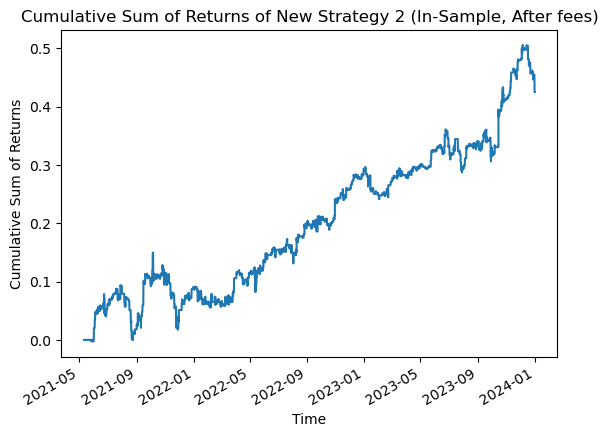

In [55]:
# Strategy 2
rets2v2ISFees = fn.backtest(dfSlowIS, dfFastIS, 
               percentile=50,
               pctShift=1,
               lags=[-1, -2, -3],
               split=2, # changed from 8
               type=5,
               sigLag=1,
               tcosts=True,
)

sharpe2v2ISFees = rets2v2ISFees.mean() / rets2v2ISFees.std() * np.sqrt(365*24)

print("New Strategy 2 - In-Sample, After Fees")
print("Sharpe Ratio After Fees: " + str(round(sharpe2v2ISFees, 3)))


ax = rets2v2ISFees.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of New Strategy 2 (In-Sample, After fees)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.show()

In [56]:
print("Strategy 2 - In-Sample Performance, Adjusted for Transaction Costs")
fn.performance_metrics(rets2v2ISFees)

Strategy 2 - In-Sample Performance, Adjusted for Transaction Costs


,Metric,Value
0,Sharpe Ratio,1.330
1,Max Drawdown (%),12.552
2,Win Rate (%),57.537
3,Annualised Returns (%),16.584
4,Average Returns per Trade (%),0.157
5,Average Winning Trade (%),0.614
6,Average Losing Trade (%),-0.619
7,Largest Winning Trade (%),5.267
8,Largest Losing Trade (%),-4.419


#### New Strategy 3

- Changed split from 10 to 2
- Changed hold period from 3 hours to 8 hours

It is important to note that making these changes has resulted in this strategy being the same as New Strategy 1. When combining these two strategies in a portfolio, we are concentrating risk in this one strategy, reducing diversification which may lead to lower risk-adjusted performance in out-of-sample testing and in live trading.

New Strategy 3 - In-Sample, After Fees
Sharpe Ratio After Fees: 1.836


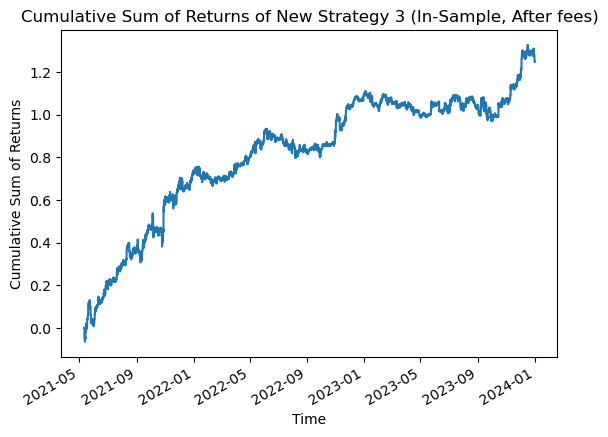

In [58]:
# Strategy 3
rets3v2ISFees = fn.backtest(dfSlowIS, dfFastIS,
               # lags=[-1, -2, -3], # Orignial
               lags=[-1, -2, -3, -4, -5, -6, -7], 
               split=2, # changed from 10
               type=6,
               sigLag=1,
               tcosts=True
)

sharpe3v2ISFees = rets3v2ISFees.mean() / rets3v2ISFees.std() * np.sqrt(365*24)

print("New Strategy 3 - In-Sample, After Fees")
print("Sharpe Ratio After Fees: " + str(round(sharpe3v2ISFees, 3)))

ax = rets3v2ISFees.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of New Strategy 3 (In-Sample, After fees)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.show()

In [59]:
print("Strategy 3 - In-Sample Performance, Adjusted for Transaction Costs")
fn.performance_metrics(rets3v2ISFees)

Strategy 3 - In-Sample Performance, Adjusted for Transaction Costs


,Metric,Value
0,Sharpe Ratio,1.836
1,Max Drawdown (%),14.788
2,Win Rate (%),55.809
3,Annualised Returns (%),55.093
4,Average Returns per Trade (%),0.232
5,Average Winning Trade (%),0.937
6,Average Losing Trade (%),-0.891
7,Largest Winning Trade (%),10.884
8,Largest Losing Trade (%),-8.969


#### New Portfolio of Strategies

New Portfolio of Strategies - In-Sample, After Fees
Sharpe Ratio After Fees: 1.909


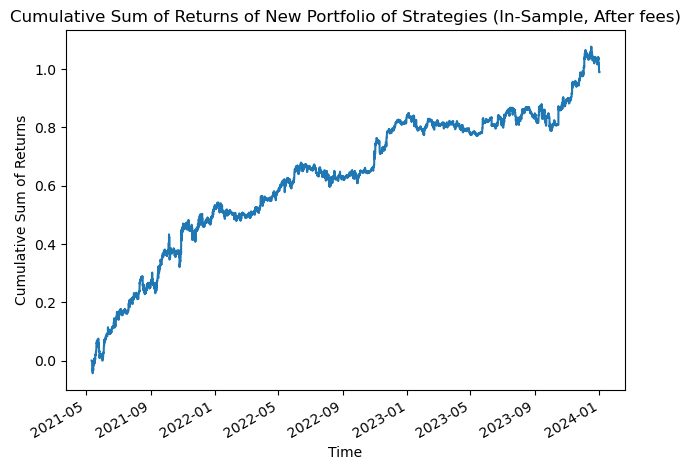

In [63]:
portv2ISFees = (rets1v2ISFees + rets2v2ISFees + rets3v2ISFees)/3
sharpePortv2ISFees = portv2ISFees.mean() / portv2ISFees.std() * np.sqrt(365*24)

print("New Portfolio of Strategies - In-Sample, After Fees")
print("Sharpe Ratio After Fees: " + str(round(sharpePortv2ISFees, 3)))

ax = portv2ISFees.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of New Portfolio of Strategies (In-Sample, After fees)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.tight_layout()
plt.show()

In [64]:
print("Portfolio of Strategies - In-Sample Performance, Adjusted for Transaction Costs")
fn.performance_metrics(portv2ISFees)

Portfolio of Strategies - In-Sample Performance, Adjusted for Transaction Costs


,Metric,Value
0,Sharpe Ratio,1.909
1,Max Drawdown (%),10.817
2,Win Rate (%),55.290
3,Annualised Returns (%),42.658
4,Average Returns per Trade (%),0.185
5,Average Winning Trade (%),0.721
6,Average Losing Trade (%),-0.663
7,Largest Winning Trade (%),6.139
8,Largest Losing Trade (%),-6.757


### Out-of-Sample Performance of New Strategies

Here, we will test the out-of-sample performance of the new strategies, accounting for transaction costs.

#### New Strategy 1

New Strategy 1 - Out-of-Sample, After Fees
Sharpe Ratio After Fees: 1.22


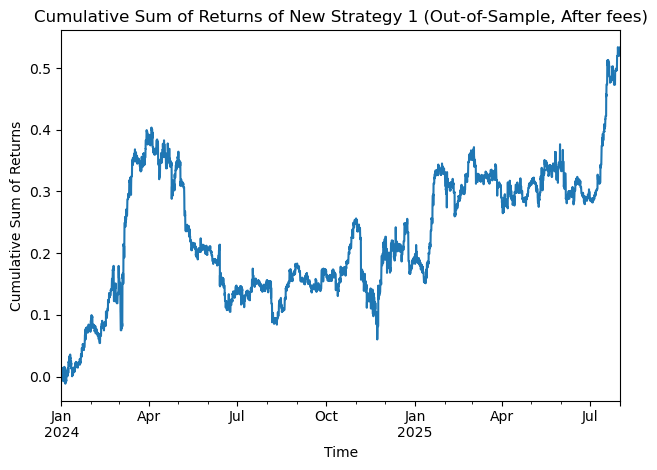

In [66]:
rets1v2OOSFees = fn.backtest(dfSlowOOS, dfFastOOS, 
               lags=[-1, -2, -3, -4, -5, -6, -7, -8], 
               split=2, # changed from 8
               type=6,
               sigLag=1,
               tcosts=True
)
sharpe1v2OOSFees = rets1v2OOSFees.mean() / rets1v2OOSFees.std() * np.sqrt(365*24)

print("New Strategy 1 - Out-of-Sample, After Fees")
print("Sharpe Ratio After Fees: " + str(round(sharpe1v2OOSFees, 3)))

ax = rets1v2OOSFees.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of New Strategy 1 (Out-of-Sample, After fees)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.tight_layout()
plt.show()

In [67]:
print("Strategy 1 - Out-of-Sample Performance, Adjusted for Transaction Costs")
fn.performance_metrics(rets1v2OOSFees)

Strategy 1 - Out-of-Sample Performance, Adjusted for Transaction Costs


,Metric,Value
0,Sharpe Ratio,1.220
1,Max Drawdown (%),30.610
2,Win Rate (%),55.536
3,Annualised Returns (%),34.599
4,Average Returns per Trade (%),0.164
5,Average Winning Trade (%),0.946
6,Average Losing Trade (%),-0.977
7,Largest Winning Trade (%),8.355
8,Largest Losing Trade (%),-7.466


#### New Strategy 2

New Strategy 2 - Out-of-Sample, After Fees
Sharpe Ratio After Fees: 1.155


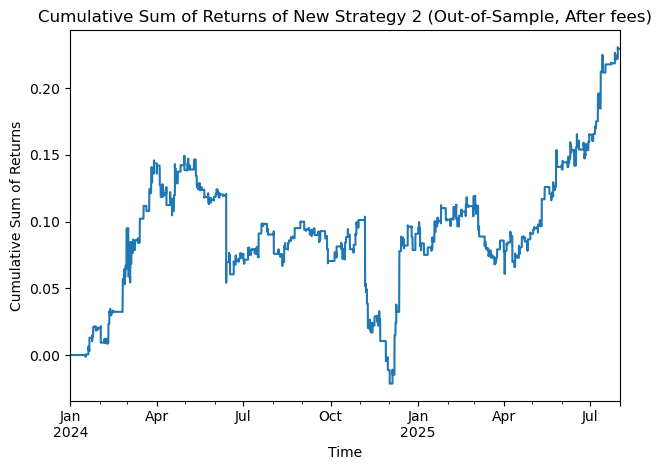

In [69]:
rets2v2OOSFees = fn.backtest(dfSlowOOS, dfFastOOS, 
               percentile=50,
               pctShift=1,
               lags=[-1, -2, -3], 
               split=2, # changed from 8
               type=5,
               sigLag=1,
               tcosts=True
)

sharpe2v2OOSFees = rets2v2OOSFees.mean() / rets2v2OOSFees.std() * np.sqrt(365*24)

print("New Strategy 2 - Out-of-Sample, After Fees")
print("Sharpe Ratio After Fees: " + str(round(sharpe2v2OOSFees, 3)))

ax = rets2v2OOSFees.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of New Strategy 2 (Out-of-Sample, After fees)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.tight_layout()
plt.show()

In [70]:
print("Strategy 2 - Out-of-Sample Performance, Adjusted for Transaction Costs")
fn.performance_metrics(rets2v2OOSFees)

Strategy 2 - Out-of-Sample Performance, Adjusted for Transaction Costs


,Metric,Value
0,Sharpe Ratio,1.155
1,Max Drawdown (%),16.156
2,Win Rate (%),57.519
3,Annualised Returns (%),14.669
4,Average Returns per Trade (%),0.150
5,Average Winning Trade (%),0.630
6,Average Losing Trade (%),-0.650
7,Largest Winning Trade (%),4.610
8,Largest Losing Trade (%),-5.110


#### New Strategy 3

New Strategy 3 - Out-of-Sample, After Fees
Sharpe Ratio After Fees: 1.22


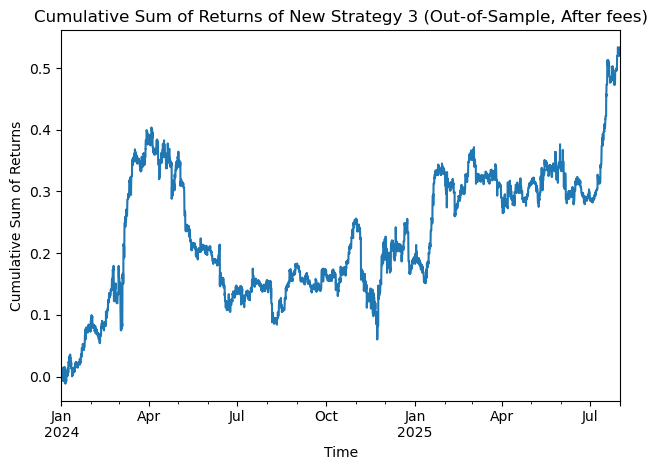

In [72]:
rets3v2OOSFees = fn.backtest(dfSlowOOS, dfFastOOS, 
               lags=[-1, -2, -3, -4, -5, -6, -7, -8], 
               # lags=[-1, -2, -3], 
               split=2, # changed from 10
               type=6,
               sigLag=1,
               tcosts=True
)

sharpe3v2OOSFees = rets3v2OOSFees.mean() / rets3v2OOSFees.std() * np.sqrt(365*24)

print("New Strategy 3 - Out-of-Sample, After Fees")
print("Sharpe Ratio After Fees: " + str(round(sharpe3v2OOSFees, 3)))

ax = rets3v2OOSFees.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of New Strategy 3 (Out-of-Sample, After fees)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.tight_layout()
plt.show()

In [73]:
print("Strategy 3 - Out-of-Sample Performance, Adjusted for Transaction Costs")
fn.performance_metrics(rets3v2OOSFees)

Strategy 3 - Out-of-Sample Performance, Adjusted for Transaction Costs


,Metric,Value
0,Sharpe Ratio,1.220
1,Max Drawdown (%),30.610
2,Win Rate (%),55.536
3,Annualised Returns (%),34.599
4,Average Returns per Trade (%),0.164
5,Average Winning Trade (%),0.946
6,Average Losing Trade (%),-0.977
7,Largest Winning Trade (%),8.355
8,Largest Losing Trade (%),-7.466


#### New Portfolio of Strategies

New Portfolio of Strategies - Out-of-Sample, After Fees
Sharpe Ratio After Fees: 1.322


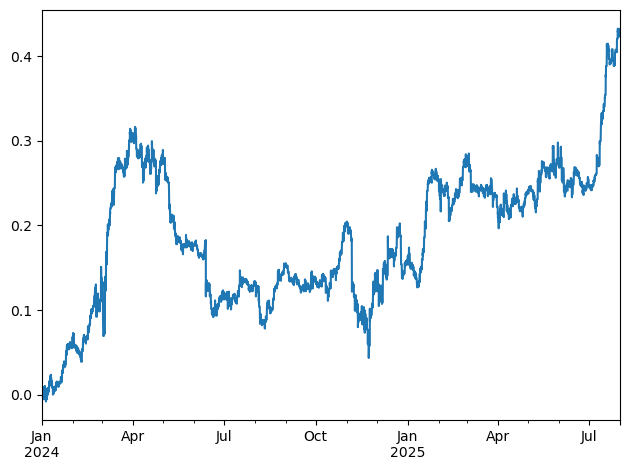

In [75]:
portv2OOSFees = (rets1v2OOSFees + rets2v2OOSFees + rets3v2OOSFees)/3
sharpePortv2OOSFees = portv2OOSFees.mean() / portv2OOSFees.std() * np.sqrt(365*24)

print("New Portfolio of Strategies - Out-of-Sample, After Fees")
print("Sharpe Ratio After Fees: " + str(round(sharpePortv2OOSFees, 3)))

portv2OOSFees.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of New Portfolio of Strategies (Out-of-Sample, After fees)")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.tight_layout()
plt.show()

In [76]:
print("Portfolio of Strategies - Out-of-Sample Performance After Fees")
fn.performance_metrics(portv2OOSFees)

Portfolio of Strategies - Out-of-Sample Performance After Fees


,Metric,Value
0,Sharpe Ratio,1.322
1,Max Drawdown (%),24.859
2,Win Rate (%),54.671
3,Annualised Returns (%),28.445
4,Average Returns per Trade (%),0.136
5,Average Winning Trade (%),0.721
6,Average Losing Trade (%),-0.706
7,Largest Winning Trade (%),6.420
8,Largest Losing Trade (%),-6.188


While each strategy exhibits positive average out-of-sample returns after accounting for transaction costs, risk-adjusted performance remains relatively low. Adjusting the underlying strategies solely to improve after-fee performance is a sub-optimal approach, as it pulls the strategy further from its underlying edge. In doing so, we risk reducing the strategy's effectiveness and robustness in exploiting market inefficiencies.

It is important to note that many exchanges offer fee reduction incentives based on trading volume, with some offering 0% maker fees at higher reward tiers. Given that trading firms typically have access to significant capital and trade frequently, they can often capitalise on these incentive structures to access lower fees. This enables these firms to implement strategies without requiring significant adjustments to account for transaciton costs, leading to better overall performance.

## Regression Analysis

The purpose of regression analysis is to determine if a strategy is producing returns that are independant from exposure to broader market movements or undelying asset performance. This is to ensure the strategy's performance is not just a result of the base assets performing well, but is a result of the strategy's edge. Here, we will compare the returns of the before-fees portfolio of strategies to BTC returns, base asset returns and a basic cross-sectional model.

For reference, the basic cross-sectional model is shown below. The strategy takes long positions in the 15 underperforming assets, and takes short positions in the 15 outperforming assets, based of the last 1 hour price performance, holding for one hour. Equal weight allocation is applied to each asset. This strategy uses the same universe of assets 

Basic XS Model - In-Sample
Sharpe Ratio After Fees: 7.199


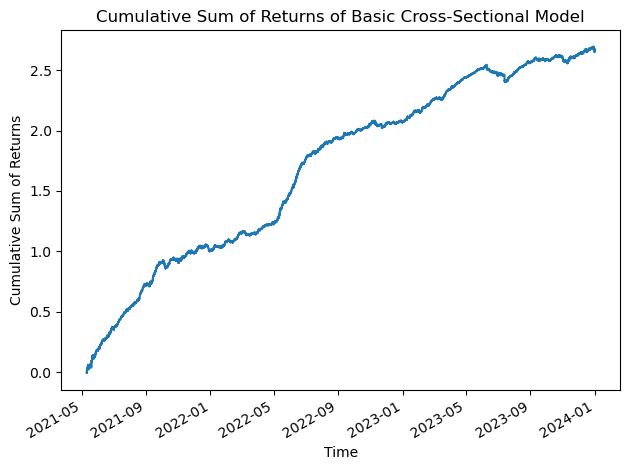

In [78]:
basicXSIS = fn.basic_XS(dfFastIS)

sharpebasicXSIS = basicXSIS.mean() / basicXSIS.std() * np.sqrt(365*24)

print("Basic XS Model - In-Sample")
print("Sharpe Ratio After Fees: " + str(round(sharpebasicXSIS, 3)))

ax = basicXSIS.cumsum().plot()
ax.set_title("Cumulative Sum of Returns of Basic Cross-Sectional Model")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Sum of Returns")
plt.tight_layout()
plt.show()

Despite its strong performance, this strategy will not work in practice due to its frequent rebalancing, as transaction costs will result in the strategy underperforming over time. The purpose of this strategy is to linear regress the portfolio of strategies against a baseline cross-sectional model, to show that the strategy has edge.

Please note: a significance level of 5% is assumed for all statistical tests.

### In-sample Regression Analysis

#### Portfolio Regressed Against BTC

In [80]:
# Linear regress against BTC returns
BTCrets = dfFastIS['BTCUSDT']['close'].pct_change()[1:]

LRrets = pd.DataFrame({
    'strategy': portIS[1:],
    'BTC': BTCrets
})

X = sm.add_constant(LRrets[['BTC']])
y = LRrets['strategy']

model = sm.OLS(y, X).fit()

print("Linear Regression - In-Sample Returns against BTC Returns")
print(model.summary())

Linear Regression - In-Sample Returns against BTC Returns
                            OLS Regression Results                            
Dep. Variable:               strategy   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     8.251
Date:                Fri, 01 Aug 2025   Prob (F-statistic):            0.00408
Time:                        20:01:21   Log-Likelihood:             1.3668e+05
No. Observations:               23151   AIC:                        -2.733e+05
Df Residuals:                   23149   BIC:                        -2.733e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

The portfolio produced statistically significant alpha of 0.003117%, with a test-statistic of 7.181 and p-value of 0.000 (rounded). The portfolio also produced statistically significant beta to BTC returns of 0.0019, with a test-statistic of 2.872 and p-value of 0.004.

#### Portfolio Regressed Against Base Assets

In [82]:
# Linear regress against base asset returns
X = sm.add_constant(retsFastIS)
y = portIS[1:]

model = sm.OLS(y, X).fit()

print("Linear Regression - In-Sample Returns against Base Asset Returns")
print(model.summary())

Linear Regression - In-Sample Returns against Base Asset Returns
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.017
Date:                Fri, 01 Aug 2025   Prob (F-statistic):           9.18e-13
Time:                        20:01:21   Log-Likelihood:             1.3673e+05
No. Observations:               23151   AIC:                        -2.734e+05
Df Residuals:                   23120   BIC:                        -2.732e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

The portfolio produced statistically significant alpha of 0.003129%, with a test-statistic of 7.219 and p-value of 0.000 (rounded). The portfolio also produced statistically significant beta to ADAUSDT, LINKUSDT, IOTAUSDT, ATOMUSDT, DOGEUSDT and ALGOUSDT. Among these, the asset with largest beta DOGEUSDT, at 0.0042. These results imply that the portfolio exhibits low but statistically significant sensitivity to the listed assets.

#### Portfolio Regressed Against Cross-Sectional Model

In [84]:
# Linear regress against basic XC model
basicXSIS = fn.basic_XS(dfFastIS)
X = sm.add_constant(basicXSIS)
y = portIS

model = sm.OLS(y, X).fit()

print("Linear Regression - In-Sample Returns against Basic XS Model")
print(model.summary())

Linear Regression - In-Sample Returns against Basic XS Model
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     161.6
Date:                Fri, 01 Aug 2025   Prob (F-statistic):           6.80e-37
Time:                        20:01:22   Log-Likelihood:             1.3676e+05
No. Observations:               23152   AIC:                        -2.735e+05
Df Residuals:                   23150   BIC:                        -2.735e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

The portfolio produced statistically significant alpha of 0.002696%, with a test-statistic of 6.213 and p-value of 0.000 (rounded). The portfolio also produced statistically significant beta to the basic cross-sectional model, at 0.0367, with a test-statistic of 12.711 and p-value of 0.000 (rounded). This implies that despite some correlation to the cross-sectional model, the portfolio is still producing a statistically meaningful edge.

### Out-of-Sample Regression

Next, we will perform regression analysis using the out-of-sample returns of the portfolio to confirm robustness.

#### Portfolio Regressed Against BTC Returns

In [86]:
# Linear regress against BTC returns
BTCrets = dfFastOOS['BTCUSDT']['close'].pct_change()[1:]

LRrets = pd.DataFrame({
    'strategy': portOOS[1:],
    'BTC': BTCrets
})

X = sm.add_constant(LRrets[['BTC']])
y = LRrets['strategy']

model = sm.OLS(y, X).fit()

print("Linear Regression - Out-of-Sample Returns against BTC Returns")
print(model.summary())

Linear Regression - Out-of-Sample Returns against BTC Returns
                            OLS Regression Results                            
Dep. Variable:               strategy   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     21.46
Date:                Fri, 01 Aug 2025   Prob (F-statistic):           3.64e-06
Time:                        20:01:22   Log-Likelihood:                 80765.
No. Observations:               13881   AIC:                        -1.615e+05
Df Residuals:                   13879   BIC:                        -1.615e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

The portfolio produced statistically significant alpha of 0.00257%, with a test-statistic of 4.209 and p-value of 0.000 (rounded). The portfolio also produced statistically significant beta to BTC returns, at 0.0052, with a test-statistic of 4.633 and p-value of 0.000 (rounded). The alpha coefficient decreased from the in-sample regression, while the beta coefficient increased. This is an indication that this strategy may have lost some of its edge over time.

#### Portfolio Regressed Against Base Asset Returns

In [88]:
# Linear regress against base asset returns
X = sm.add_constant(retsFastOOS)
y = portOOS[1:]

model = sm.OLS(y, X).fit()

print("Linear Regression - Out-of-Sample Returns against Base Asset Returns")
print(model.summary())

Linear Regression - Out-of-Sample Returns against Base Asset Returns
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.478
Date:                Fri, 01 Aug 2025   Prob (F-statistic):           4.53e-15
Time:                        20:01:22   Log-Likelihood:                 80821.
No. Observations:               13881   AIC:                        -1.616e+05
Df Residuals:                   13850   BIC:                        -1.613e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

The portfolio produced statistically significant alpha of 0.00261%, with a test-statistic of 4.283 and p-value of 0.000 (rounded). The portfolio also produced statistically significant beta to LTCUSDT, LINKUSDT, UNIUSDT, COMPUSDT, CRVUSDT and ALGOUSDT. Among these, LTCUSDT had the beta with the larget magnitude, with -0.0030. These results imply that the portfolio exhibits low but statistically significant sensitivity to the listed assets.

#### Portfolio Regressed Against Cross-Sectional Model

In [90]:
# Linear regress against basic XS Model
basicXSOOS = fn.basic_XS(dfFastOOS)
X = sm.add_constant(basicXSOOS)
y = portOOS

model = sm.OLS(y, X).fit()

print("Linear Regression - Out-of-Sample Returns against Basic XS Model")
print(model.summary())

Linear Regression - Out-of-Sample Returns against Basic XS Model
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     111.7
Date:                Fri, 01 Aug 2025   Prob (F-statistic):           5.27e-26
Time:                        20:01:22   Log-Likelihood:                 80816.
No. Observations:               13882   AIC:                        -1.616e+05
Df Residuals:                   13880   BIC:                        -1.616e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

The portfolio produced statistically significant alpha of 0.002328%, with a test-statistic of 3.822 and p-value of 0.000 (rounded). The portfolio also produced statistically significant beta to the basic cross-sectional model, at 0.0414, with a test-statistic of 10.568 and p-value of 0.000 (rounded). This implies that despite some correlation to the cross-sectional model, the portfolio is still producing a statistically meaningful own edge, even across the out-of-sample dataset.

## Conclusion

### Strategy Development and Performance

In this report, we developed a portfolio of cross-sectional reversal trading strategies inspired by the concept of impulse candles, aiming to detect impluse candles on the 1-day timeframe, and trade the reversal on the 1-hour timeframe. Various variables were altered and tested, and a collection of 3 strategies were developed and combined together into a portfolio. The performance metrics of the portfolio of strategies are displayed below:

| Metric              | In-Sample  | Out-of-Sample  |
|---------------------|------------|----------------|
| Sharpe Ratio        | 4.419      | 3.400          |
| Max Drawdown        | 2.825%     | 2.728%         |
| Annualised Returns  | 31.166%    | 25.458%        |


### Analysis of Transaction Costs

#### Base Strategies

Analysis was conducted to assess the effect of transaction costs on the performance of each strategy and the portfolio. Measures were taken to account for no rebalancing mid-trade, with the assumption of 7 basis points per trade used to account for exchange fees. The performance metrics of the portfolio of strategies after accounting for transaction costs are displayed below:

| Metric              | In-Sample |
|---------------------|-----------|
| Sharpe Ratio        | 1.000     |
| Max Drawdown        | 7.584%    |
| Annualised Returns  | 6.178%    |


#### Adjusting Strategies for Transaction Costs

The base strategies were then adjusted to improve performance after accounting for fees. Reducing the number of assets held and increasing hold times can reduce the overall impact that transaction costs have on performance, as it opens the opportunity for higher returns to aliviate the costs. However, this comes with a reduction in before-fee risk-adjusted performance.

Having to significantly adjust strategies to account for transaction costs is a sub-optimal approach, as it pulls the strategy further away from its underlying edge. Access to lower fee rates through exchange incentive structures will reduce the need for adjustments, making higher risk-adjusted returns more feasible to achieve. The performance metrics of the portfolio of strategies after making adjustments and accounting for transaction costs are displayed below:

| Metric              | In-Sample | Out-of-Sample |
|---------------------|-----------|---------------|
| Sharpe Ratio        | 1.909     | 1.322         |
| Max Drawdown        | 10.817%   | 24.859%       |
| Annualised Returns  | 42.658%   | 28.445%       |


### Regression Analysis

Regression analysis was conducted on the original portfolio of strategies (before adjustments) against BTC, all assets used in the strategy, and a basic cross-sectional trading strategy, with the intention of determining whether the strategy is producing returns that are independant from the broader market. Upon conducting the analysis, we found that the portfolio was producing statistically significant returns that were independent of the tested factors. The results are shown below:

| Model                                | Alpha (%) | t-Stat  | p-value | Beta      | t-Stat  | p-value |
|--------------------------------------|-----------|---------|---------|-----------|---------|---------|
| In-Sample: BTC Returns               | 0.003117  | 7.181   | 0.000   | 0.0019    | 2.872   | 0.004   |
| In-Sample: Base Assets Returns       | 0.003129  | 7.219   | 0.000   | -         | -       | -       |
| In-Sample: Cross-Sectional Model     | 0.002696  | 6.213   | 0.000   | 0.0367    | 12.711  | 0.000   |
| Out-of-Sample: BTC Returns           | 0.002570  | 4.209   | 0.000   | 0.052     | 4.633   | 0.000   |
| Out-of-Sample: Base Assets Returns   | 0.002610  | 4.283   | 0.000   | -         | -       | -       |
| Out-of-Sample: Cross-Sectional Model | 0.002328  | 3.822   | 0.000   | 0.0414    | 10.568  | 0.000   |

The alpha coefficients consistently reduced between the in-sample and the out-of-sample sets, indicating that the strategies may have lost some of their edge over time.

### Ideas for Future Development

The process of building and testing these strategies led to several ideas for further development. In practice, strategy design is an iterative process. Testing one idea often uncovers many more worth exploring. Some ideas for futher development are listed below:

- **Diversifying with Momentum Strategies:** Momentum and reversal strategies often exhibit low or negative correlation, as they exploit different price behaviours. Combining momentum strategies with our reversal strategies could enhance risk-adjusted returns of the portfolio through diversification.

- **Perpetual Reversal Strategy with 8-hour Rebalancing:** Based on patterns observed in this reports' strategies, maintaining constant market exposure with periodic rebalancing may offer higher returns. This also opens up the opportunity for efficient rebalancing mechanisms to reduce transaction costs while maintaining risk-adjusted performance.

- **Using Seperate Universes for Different Strategies:** Constructing each strategy using a separate set of assets (with minimal overlap) may further reduce correlation between strategies. This could result in a more diversified and higher-performing portfolio.

These ideas illustrate how strategy development is rarely a linear process. Each idea can unlock further options for testing and refinement.


### Key Takeaways from Strategy Development

Throughout the construction and evaluation of these trading strategies, several important insights were made:

- **Prioritise Core Logic Over Parameter Optimisation:** Rather than over-optimising inputs, focusing on the strategy’s underlying logic was found to produce higher and more consistant performance. For example, in the reversal strategies developed in this report, percentile lookback length and volume moving average length were kept constant for all strategies.

- **Timeframe of Reversals:** The effectiveness of reversal signals varied depending on the timeframes used. Combining the 1-day and 1-hour timeframes was found to produce the most consistent results, while replacing the 1-hour with a 4-hour signal lead to inconsistant performance. 

- **Impact of Rebalancing Frequency:** Frequent rebalancing helps to maintain target weights but increased slippage and fees. Avoiding mid-trade rebalancing proved beneficial for the strategies.

These insights will assist in future strategy development, helping to build more robust, high performing trading systems.